In [99]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd

from astropy.io import fits
import astropy.units as u

import scipy
from scipy.constants import e as elem
from scipy.integrate import quad 
from scipy.optimize import curve_fit
from scipy import signal 
from scipy import stats
from uncertainties import ufloat
from uncertainties import unumpy as unp

from random import randint
from random import uniform 

from ebltable.tau_from_model import OptDepth
tau =  OptDepth.readmodel(model = 'dominguez')

from Gilmore_simulation import calculatesignificance,calculaterate
from Gilmore_simulation import calculaterate_GBM
from Gilmore_simulation import plot_simulation, integrate_background

from spectra import make_DF_from_GBM
from spectra import plot_Flux_Energy 
from spectra_LAT import plot_Flux_Energy_LAT 
from spectra_LAT import make_DF_from_LGRB
from spectra import make_DF_from_GBM, make_DF_from_BATSE

from Sensitivity import plot_Sens
from Sensitivity import plot_ctools_Crab, plot_HEGRA_Crab

from Fitting_models import Plaw_LAT
from Lightcurve import fit_LC_simple_Gaussian,fit_LC_small_Gaussian, save_LAT_txt,Gauss, exp, reset_txt
from Lightcurve import rescale_x,rescale_y

tugreen = '#73ae14'
cmap = plt.cm.get_cmap('viridis')
viridis10 = cmap(0.1)
viridis9 = cmap(0.2)
viridis8 = cmap(0.28)
viridis7 = cmap(0.35)
viridis6 = cmap(0.42)
viridis5 = cmap(0.5)
viridis4 = cmap(0.6)
viridis3= cmap(0.7)
viridis2 = cmap(0.82)
viridis1 = cmap(0.9)
viridis0 = cmap(0.98)

## Spectrum 

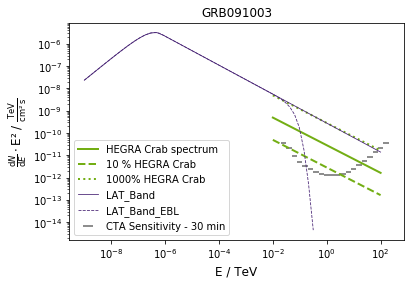

In [18]:
plot_Sens('Tev','binwise')
plot_HEGRA_Crab(-2,2,True)
plot_Flux_Energy_LAT('GRB090926',-9,2,True,False,0,viridis10)
plot_Flux_Energy_LAT('GRB090926',-9,-0.5,True,True,2.14,viridis10)
#plt.savefig('Plots/GRB_Example.pdf',bbox_inches = 'tight')
plt.savefig('Plots/jpeg/GRB_Example.jpeg',bbox_inches = 'tight')
plt.clf()
plot_Sens('Tev','binwise')
plot_HEGRA_Crab(-2,2,True)
plot_Flux_Energy_LAT('GRB091003',-9,2,True,False,0,viridis10)
plot_Flux_Energy_LAT('GRB091003',-9,-0.5,True,True,2.14,viridis10)
#plt.savefig('Plots/GRB_Example2.pdf',bbox_inches = 'tight')
plt.savefig('Plots/jpeg/GRB_Example2.jpeg',bbox_inches = 'tight')

In [20]:
'''
Fitting functions
'''
def Plaw(E,E0,Phi,alpha):
    return Phi*(E/E0)**(-alpha)*E
def Plaw_u(E,E0,Phi,alpha):
    return Phi*(E/E0)**(-alpha)
@np.vectorize
def Broken(E,E0,EB,Phi,alpha1,alpha2):
    if E <= EB:
        return Phi*(E/E0)**(-alpha1)
    else:
        return Phi*(EB/E0)**(alpha2-alpha1)*(E/E0)**(-alpha2)
'''
Fits
'''
## IC310
Flux = ufloat(6.08e-11,0.29e-11)/1## per cm² time, not per energy or *energy 
alpha = ufloat(1.90,0.04)
E0 = 1 
Int = quad(Plaw,0.0001,0.3,args=(E0,1,alpha.n)) ; Integral = ufloat(Int[0],Int[1])
Phi0 = Flux/(Integral)
Eplot = np.linspace(0.001,100)
Results = Plaw(Eplot,E0,Phi0,alpha)
Values = unp.nominal_values(Results)
Errors = unp.std_devs(Results)

## HESS
Flux = ufloat(0.71e-11,0.15e-11)*1e-19/elem # aus erg pro Sekunde in TeV pro cm² s 
alpha = ufloat(2.45,0.05)
E0 = 1
Int = quad(Plaw,0.0001,0.3,args=(E0,1,alpha.n)) ; Integral = ufloat(Int[0],Int[1])
Phi0 = Flux/(Integral)
Eplot = np.linspace(0.001,100)
Results = Plaw_u(Eplot,E0,Phi0,alpha)
Values = unp.nominal_values(Results)
Errors = unp.std_devs(Results)

## LSI
Phi0 = ufloat(2.7e-12,0.6e-12)
alpha = ufloat(2.6,0.2)
Eplot = np.linspace(0.001,100)
Results = Plaw_u(Eplot,E0,Phi0,alpha)
Values_LS = unp.nominal_values(Results)
Errors_LS = unp.std_devs(Results)

## PKS 
Phi0 = ufloat(1.81e-12,0.13e-12)
alpha = ufloat(3.53,0.06)
E0 = 1 
Phi0_Flare = ufloat(2.06e-10,0.16e-10)
alpha_Flare = ufloat(2.71,0.06)
beta_Flare= ufloat(3.53,0.05)
EB_Flare = ufloat(0.430,0.022) # GeV 

Eplot = np.linspace(0.001,100)
Results = Plaw_u(Eplot,E0,Phi0,alpha)
Values = unp.nominal_values(Results)
Errors = unp.std_devs(Results)

Results_Flare = Broken(Eplot,E0,EB_Flare,Phi0_Flare,alpha_Flare,beta_Flare)
Values_Flare = unp.nominal_values(Results_Flare)
Errors_Flare = unp.std_devs(Results_Flare)

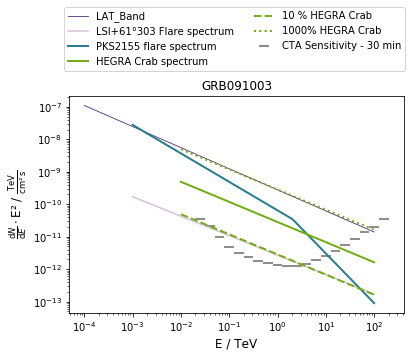

In [23]:
plot_Flux_Energy_LAT('GRB091003',-4,2,True,False,1.99,viridis10)
#plot_Flux_Energy_LAT('GRB090926',-4,2,True,False,1.99,'indigo')
#plot_Flux_Energy_LAT('GRB110721',-4,2,True,False,1.99,'indigo')
Eplot = np.linspace(0.001,100)
plt.plot(Eplot,Values_LS*Eplot*Eplot, color='thistle',label='LSI+61°303 Flare spectrum')
plt.plot(Eplot,Values_Flare*Eplot*Eplot, color=viridis6,lw=2,label='PKS2155 flare spectrum')
plot_Sens('Tev','binwise')
plot_HEGRA_Crab(-2,2,True)
plt.legend(bbox_to_anchor=(-0.03, 1.09, 1., .101),ncol=2)
plt.savefig('Plots/Comparison.pdf')
#plt.savefig('Plots/jpeg/Comparison.jpeg')

## Lightcurves LC 

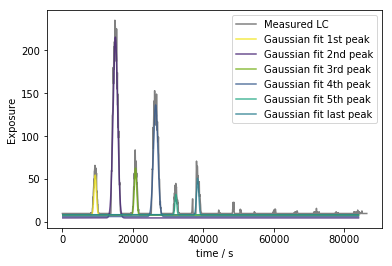

In [29]:
x,y = np.genfromtxt('DATA/LC_SOLAR/Flare20120307.txt', unpack=True)
plt.plot(x,y+10,color='grey', label='Measured LC')

params, cov = curve_fit(Gauss, x,y, p0=(50,15000,100,0))
params1, cov = curve_fit(Gauss, x,y, p0=(200,10000,100,0))
params2, cov = curve_fit(Gauss, x,y, p0=(100,21000,100,0))
params3, cov = curve_fit(Gauss, x,y, p0=(150,27000,100,0))
params4, cov = curve_fit(Gauss, x,y, p0=(30,32000,100,0))
params5, cov = curve_fit(Gauss, x,y, p0=(50,38000,100,0))
xlin = np.linspace(100,84000, 1000000)

plt.plot(xlin,Gauss(xlin,*params1),color=viridis0, alpha = 0.8, label='Gaussian fit 1st peak')
plt.plot(xlin,Gauss(xlin,*params),color=viridis10, alpha = 0.8, label='Gaussian fit 2nd peak')
plt.plot(xlin,Gauss(xlin,*params2),color=tugreen, alpha = 0.8, label='Gaussian fit 3rd peak')
plt.plot(xlin,Gauss(xlin,*params3),color=viridis8, alpha = 0.8, label='Gaussian fit 4th peak')
plt.plot(xlin,Gauss(xlin,*params4),color=viridis4, alpha = 0.8, label='Gaussian fit 5th peak')
plt.plot(xlin,Gauss(xlin,*params5),color=viridis6, alpha = 0.8, label='Gaussian fit last peak')
#plt.xlim(0,10000)
plt.xlabel('time / s')
plt.ylabel('Exposure')
plt.legend() ; plt.savefig('Plots/SolarFlares.pdf')
plt.show()

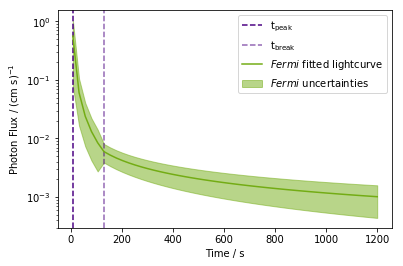

In [30]:
def Simple(t,tp,alpha,F0):
    return F0*(t/tp)**(-alpha)

@np.vectorize
def Broken(t,tb,alpha1, alpha2,F0):
    if t< tb:
        return F0*(t/tb)**(-alpha1)
    else:
        return F0*(t/tb)**(-alpha2)

plt.ylabel('Photon Flux / (cm s)$^{-1}$')
plt.xlabel('Time / s')
xlin = np.linspace(9,100)
tp = ufloat(9,1)
alpha = ufloat(1.56,0.06)
F0 = ufloat(600,100)*1e-5

Values = Simple(xlin,tp,alpha,F0)
Val = unp.nominal_values(Values)
Err = unp.std_devs(Values)
plt.axvline(9, label='t$_{\mathrm{peak}}$', ls='--', color='indigo')
plt.plot(xlin,Val, color='#73ac14', label='$Fermi$ fitted lightcurve')
plt.fill_between(xlin,Val-Err,Val+Err,color='#73ac14', lw=1, alpha=0.5, label='$Fermi$ uncertainties')
plt.yscale('log')
plt.legend()
plt.savefig('Plots/Simple_Powerlaw.pdf', bbox_inches= 'tight')
#plt.savefig('Plots/jpeg/Simple_Powerlaw.jpeg', bbox_inches= 'tight')
plt.clf()

plt.ylabel('Photon Flux / (cm s)$^{-1}$')
plt.xlabel('Time / s')
xlin = np.linspace(9,1200)
tb = ufloat(130,50,1)
alpha1 = ufloat(1.7,0.2)
alpha2 = ufloat(0.8,0.2)
F0 = ufloat(600,100)*1e-5

Values = Broken(xlin,tb,alpha1,alpha2,F0)
Val = unp.nominal_values(Values)
Err = unp.std_devs(Values)
plt.axvline(9, label='t$_{\mathrm{peak}}$', ls='--', color='indigo')
plt.axvline(130, label='t$_{\mathrm{break}}$', ls='--', color='indigo', alpha=0.6)
plt.plot(xlin,Val, color='#73ac14', label='$Fermi$ fitted lightcurve')
plt.fill_between(xlin,Val-Err,Val+Err,color='#73ac14', lw=1, alpha=0.5, label='$Fermi$ uncertainties')
plt.yscale('log')
plt.legend()
plt.savefig('Plots/Broken_Powerlaw.pdf', bbox_inches= 'tight')
#plt.savefig('Plots/jpeg/Broken_Powerlaw.jpeg', bbox_inches= 'tight')

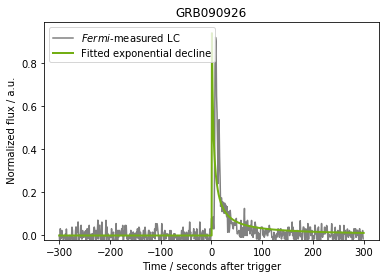

In [37]:
#reset_txt()
@np.vectorize
def Step_exp(t,tp,Fp,b ,alpha):
    if t < tp:
        return float(0)  # uniform data types 
    if t >= tp:
        return float(Fp*(t/tp-b)**(-alpha))

rescale_x('/home/jana/Schreibtisch/Projekt_Master/Project_Master/DATA/LC/LAT_090902.txt')
rescale_y('/home/jana/Schreibtisch/Projekt_Master/Project_Master/DATA/LC/LAT_090902.txt')
x,y = np.genfromtxt('/home/jana/Schreibtisch/Projekt_Master/Project_Master/DATA/LC/LAT_090902.txt', unpack=True, skip_header=1 ) ; y=y-y[0]
plt.plot(x-300,y,'-',color='grey', label='$Fermi$-measured LC')
x2 =np.linspace(-300,300,1000)
y2 = Step_exp(x2,0.71,0.27,-3,0.95)/ Step_exp(0.71,0.71,0.27,-3,0.95)
plt.plot(x2,y2, color=tugreen,lw=2, label='Fitted exponential decline')
plt.legend()
plt.ylabel(r' Normalized flux / a.u.')
plt.xlabel('Time / seconds after trigger')
plt.ylim(-0.02)
plt.title('GRB090926')
#plt.savefig('Plots/jpeg/Exponential.jpg')
plt.savefig('Plots/Exponential.pdf')

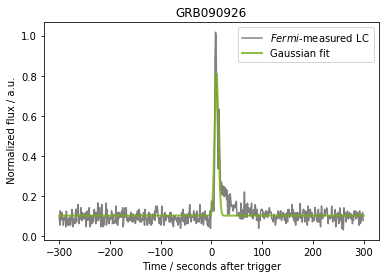

In [44]:
rescale_x('/home/jana/Schreibtisch/Projekt_Master/Project_Master/DATA/LC/LAT_090902.txt')
rescale_y('/home/jana/Schreibtisch/Projekt_Master/Project_Master/DATA/LC/LAT_090902.txt')
x,y = np.genfromtxt('/home/jana/Schreibtisch/Projekt_Master/Project_Master/DATA/LC/LAT_090902.txt', unpack=True, skip_header=1 )
A0 = y.max() ; index = np.argmax(y)
mu0 = x[index] ## Mitte / Peak, ab hier -1 für exp. Fit
y = y+abs(y.min())+1e-3

plt.plot(x-300,y,'-',color='grey', label='$Fermi$-measured LC')
params, cov = curve_fit(Gauss, x,y,p0=(2,mu0,5,0)) ;  errors = np.sqrt(np.diag(cov))
xlin = np.linspace(0,600, 10000)
plt.plot(xlin-300,Gauss(xlin,*params),color=tugreen,lw=2, alpha = 0.8, label='Gaussian fit')

plt.ylabel(r' Normalized flux / a.u.')#
plt.xlabel('Time / seconds after trigger')
plt.legend() ;
plt.title('GRB090926')
#plt.savefig('Plots/Simple_Gauss.pdf')
plt.savefig('Plots/jpeg/Simple_Gauss.jpeg')
plt.show()

42

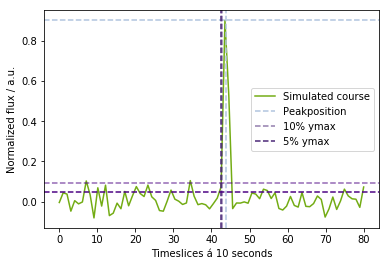

In [47]:
def Gauss_Norm(x, x0, sigma,b):
    return np.exp(-(x-x0)**2/(2*sigma**2))+b
def x_from_y_Gauss(percentage,y,sigma,mu):
    return -np.sqrt(2*np.log(1/(percentage*y)))*sigma+mu

def simulate_Gaussians(sigma_range_min,sigma_range_max,Num_slices,time_per_slice):
    time = Num_slices*time_per_slice 
    '''
    Rescale sigmas to given time & randomply drag a float sigma value 
    '''
    sigma_range_min_time = sigma_range_min/(600)*time 
    sigma_range_max_time = sigma_range_max/(600)*time 
    sigma = uniform(sigma_range_min_time,sigma_range_max_time)

    '''
    Adjust possible positions for the peak: mu 
    Start with 3 slices + 1 sigma before peak 
    End with 3 sliced and 1 sigma after peak 
    '''
    mu_min = sigma_range_max_time+time_per_slice*3
    mu_max = Num_slices*time_per_slice -3*time_per_slice -sigma_range_max_time
    mu = uniform(mu_min,mu_max)

    '''
    Calculate #N_slices values, normal distributed around random mu and sigma 
    '''
    xlin = np.linspace(0,time,Num_slices)
    ylin = Gauss_Norm(xlin,mu,sigma,0)
    y = ylin.max() 
    ylin = ylin/y
    noise = np.random.normal(0,0.04, ylin.shape)
    ylin = ylin + noise
    
    
    plt.plot(xlin/time_per_slice ,ylin,'-', color='#73ac14',label='Simulated course')
    plt.axvline(mu/time_per_slice ,linestyle='--', color='lightsteelblue', label='Peakposition')
    plt.axhline(ylin.max(),linestyle='--', color='lightsteelblue')
    plt.axvline(x_from_y_Gauss(0.1,y,sigma,mu)/time_per_slice , linestyle='--', color=viridis10,alpha=0.6,label='10% ymax')
    plt.axhline(0.1*ylin.max(),linestyle='--', color='indigo', alpha=0.6)

    plt.axvline(x_from_y_Gauss(0.05,y,sigma,mu)/time_per_slice, linestyle='--', color=viridis10,label='5% ymax')
    plt.axhline(0.05*ylin.max(),linestyle='--', color='indigo')
    True_Start = int(x_from_y_Gauss(0.05,y,sigma,mu)/time_per_slice) # Number of slice 
    
    plt.legend()
    #plt.xlim(20,40)
    plt.xlabel('Timeslices á 10 seconds')
    plt.ylabel('Normalized flux / a.u.')
    return ylin, True_Start
    
    
y,True_Start = simulate_Gaussians(1.8348,16.0364,80,10)
plt.savefig('Plots/New_Results_21.pdf')
True_Start   ## +/- 2 Slices Toleranz 

3

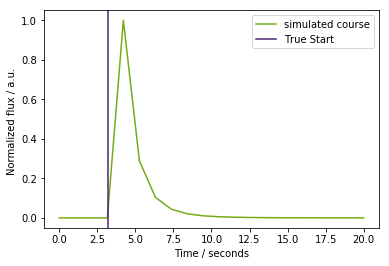

In [79]:
@np.vectorize
def Step_exp(t,tp,Fp,b ,alpha):
    if t < tp:
        return float(0)  # uniform data types 
    if t >= tp:
        return float(Fp*(t/tp+b)**(-alpha))

alpha_min = 3
b_min = 0
alpha_max = 6
b_max = 2

def simulate_Exponential(alpha_min,alpha_max,b_min,b_max,Num_slices,time_per_slice):
    time = Num_slices*time_per_slice 
    alpha_min_time = alpha_min
    b_min_time = b_min/600*time
    alpha_max_time = alpha_max
    b_max_time = b_max/600*time
    
    b = uniform(b_min_time,b_max_time)
    alpha = uniform(alpha_min_time, alpha_max_time)
    tp = uniform(0,time/3)
    params = np.array([tp,1,b,alpha])

    x2 =np.linspace(0,time,Num_slices)
    y2 = Step_exp(x2,params[0], params[1], params[2], params[3])
    y2 = y2/y2.max()
    noise = np.random.normal(0,0.00, y2.shape)
    y2 = y2 + noise
    
    plt.plot(x2/time_per_slice,y2, color='#73ac14',label='simulated course')
    plt.axvline(tp/time_per_slice,color=viridis10, label='True Start')
    plt.xlabel('Time / seconds')
    plt.ylabel(r'Normalized flux / a.u. ')
    plt.legend()
    True_Start = tp/time_per_slice
    return y2,int(True_Start)

y,True_Start = simulate_Exponential(alpha_min,alpha_max,b_min,b_max,20,10)
plt.savefig('Plots/New_Results_20.pdf')
#plt.savefig('Plots/jpeg/New_Results_20.jpeg')
True_Start

## Expectation calculations 

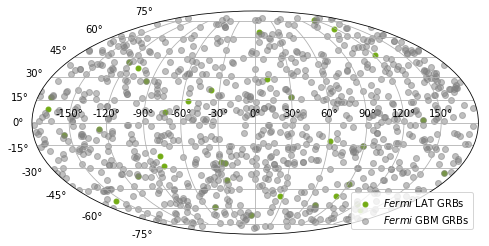

In [81]:
'''
Isotropic density due to extragalactic origin 
'''
### Isotropie aus Katalog plotten und zeigen 
Datei = fits.open('Kataloge/LATGRB.fits',ignore_missing_end=True)
Kat = Datei['FermiLGRB']
Ra = Kat.data['RA']
Dec = Kat.data['DEC']
import astropy.coordinates as coord
ra = coord.Angle(Ra*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(Dec*u.degree)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.grid(True)
ax.scatter(ra.radian, dec.radian, color='#73ac14',s=24, label='$Fermi$ LAT GRBs')

Datei = fits.open('Kataloge/GRBST.fits',ignore_missing_end=True)
Kat = Datei['FERMIGBRST']
Ra = Kat.data['RA']
Dec = Kat.data['DEC']
import astropy.coordinates as coord
ra = coord.Angle(Ra*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(Dec*u.degree)
ax.scatter(ra.radian, dec.radian, color='grey',alpha=0.5, label='$Fermi$ GBM GRBs')
plt.legend(loc='lower right')
plt.savefig('Plots/Isotropy.pdf')
#plt.savefig('Plots/jpeg/Isotropy.jpeg')

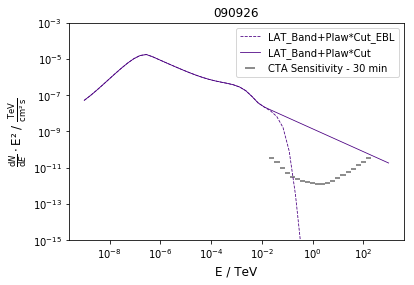

In [106]:
from Gilmore_simulation import simulate_BATSE_detection, simulate_GBM_detection, simulate_LAT_detection 
simulate_LAT_detection('/home/jana/Schreibtisch/Projekt_Master/caldb/data/cta/prod3b/bcf/South_z20_average_30m/irf_file.fits',
                       '090926',1800,4)
plt.show()

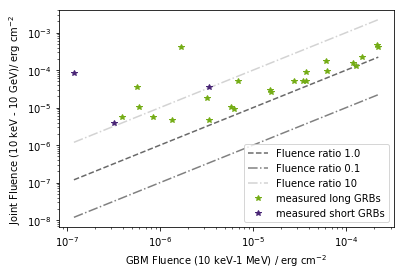

In [86]:
DF = make_DF_from_GBM('Kataloge/GRBST.fits')
LAT_DF = make_DF_from_LGRB('Kataloge/LATGRB.fits')
GBM_Flu = np.zeros(26) ; Flu_LAT = np.zeros(26)
Fast_GBM = np.zeros(4) ; Fast_LAT = np.zeros(4)
index, index2 = 0,0

for i in LAT_DF['Name']:
    LAT = LAT_DF[LAT_DF.Name.str.contains(i)]
    Table = DF[DF.Name.str.contains(i[0:9])]
    if len(Table) == 1:  
        
        if Table['T90/s'].iloc[0] > 2: 
            GBM_Flu[index] = Table['Fluence'].iloc[0]
            Flu_LAT[index] = LAT['Fluence']
            index +=1
        else:
            Fast_GBM[index2] = Table['Fluence'].iloc[0]
            Fast_LAT[index2] = LAT['Fluence']
            index2 +=1 
    if len(Table) == 2:
        if Table['T90/s'].iloc[0] > 2: 
            GBM_Flu[index] = Table['Fluence'].iloc[0]
            Flu_LAT[index] = LAT['Fluence']
            index +=1
        if Table['T90/s'].iloc[1] > 2: 
            GBM_Flu[index] = Table['Fluence'].iloc[1]
            Flu_LAT[index] = LAT['Fluence']
            index +=1
        if Table['T90/s'].iloc[0] <= 2:
            Fast_GBM[index2] = Table['Fluence'].iloc[0]
            Fast_LAT[index2] = LAT['Fluence'] 
            index2 +=1
        if Table['T90/s'].iloc[1] <= 2:
            Fast_GBM[index2] = Table['Fluence'].iloc[1]
            Fast_LAT[index2] = LAT['Fluence'] 
            index2 +=1 
            
plt.xlabel('GBM Fluence (10 keV-1 MeV) / erg cm$^{-2}$') 
plt.ylabel('Joint Fluence (10 keV - 10 GeV)/ erg cm$^{-2}$') 
plt.xscale('log') ; plt.yscale('log')
x = np.linspace(Fast_GBM.min(),GBM_Flu.max())
plt.plot(x,x,'--',color='dimgray',label='Fluence ratio 1.0')
plt.plot(x,0.1*x,'-.',color='gray',label='Fluence ratio 0.1')
plt.plot(x,10*x,'-.',color='lightgray',label='Fluence ratio 10')
plt.plot(GBM_Flu,Flu_LAT,'*',color='#73ac14',label='measured long GRBs')
plt.plot(Fast_GBM,Fast_LAT,'*',color=viridis10,label='measured short GRBs')
plt.legend()
plt.savefig('Plots/LAT_GBM_Fluence.pdf',bbox_inches='tight')
#plt.savefig('Plots/jpeg/LAT_GBM_Fluence.jpg',bbox_inches='tight')

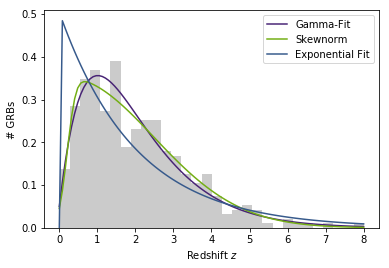

2.0820486455090523

In [98]:
## Redshifts
Name,Flu,z = np.genfromtxt('Kataloge/SWIFT.txt',unpack=True)
Flu = Flu*1e-7 # in erg/cm² between 15 and 150 keV 
## Redshift 
plt.hist(z[z>0],bins=30,color='darkgray',density=True, alpha=0.6)
plt.xlabel('Redshift $z$') ; plt.ylabel('# GRBs')

gamma = stats.gamma
x = np.linspace(0, z[z>0].max(), 100)
param = gamma.fit(z[z>0]) ; pdf_fitted = gamma.pdf(x, *param)
a = param[0]
plt.plot(x, pdf_fitted, color=viridis10, label='Gamma-Fit')

skewnorm = stats.skewnorm
param = skewnorm.fit(z[z>0]) ; pdf_fitted = skewnorm.pdf(x, *param)
plt.plot(x, pdf_fitted, color=tugreen, label='Skewnorm')

P = stats.expon.fit(z[z>0])
rX = np.linspace(0,8, 100) ; rP = stats.expon.pdf(rX, *P)
plt.plot(rX, rP, color=viridis8, label='Exponential Fit')
plt.legend()
plt.savefig('Plots/SWIFT_Redshifts.pdf',bbox_inches='tight')
#plt.savefig('Plots/jpeg/SWIFT_Redshifts.jpg',bbox_inches='tight')
plt.show() ; plt.clf()
## Test density 
r = gamma.rvs(a, size=1000)
a

Length of Lowest regime (0-1.2) =  118
Length of Middle regime (1.2-2.43)=  119
Length of Highest regime (>2.43) =  119
The higher the redshfit, the higher the fluence needed for a detection


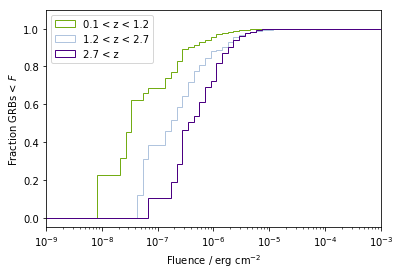

Pearson correlation Redshift to Fluence:  -0.119884970133


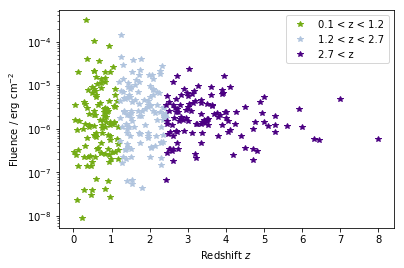

In [100]:
SWIFT_DF = pd.DataFrame({'Name': Name,'Fluence':Flu , 'Redshift': z   
                         })
All_z = SWIFT_DF[SWIFT_DF['Redshift']>0]
Low_z = All_z[All_z['Redshift']<1.2]
Config_z = All_z[All_z['Redshift']>1.2]
Mid_z = Config_z[Config_z['Redshift']<2.43]
High_z = All_z[All_z['Redshift']>2.43]
# Rates
print('Length of Lowest regime (0-1.2) = ',len(Low_z['Redshift']))
print('Length of Middle regime (1.2-2.43)= ',len(Mid_z['Redshift']))
print('Length of Highest regime (>2.43) = ',len(High_z['Redshift']))
# Histogramm 
binning = np.logspace(-9,-3,60)
plt.hist(Low_z['Fluence'],histtype = 'step',cumulative=True, bins=binning,density=True,
        color='#73ac14', label='0.1 < z < 1.2')
plt.hist(Mid_z['Fluence'],histtype = 'step',cumulative=True,bins=binning, density=True,
        color='lightsteelblue', label='1.2 < z < 2.7')
plt.hist(High_z['Fluence'],histtype='step',cumulative=True,bins=binning,density=True,
        color='indigo', label='2.7 < z')

print('The higher the redshfit, the higher the fluence needed for a detection')

plt.xscale('log')
plt.ylim(-0.05,1.1) ; plt.xlim(1e-9,1e-3)
plt.xlabel('Fluence / erg cm$^{-2}$') ; plt.ylabel('Fraction GRBs < $F$')
plt.legend(loc ='upper left')
plt.savefig('Plots/SWIFT_z_Fluence.pdf',bbox_inches='tight') ;plt.show(); plt.clf()
#plt.savefig('Plots/jpeg/SWIFT_z_Fluence.jpg',bbox_inches='tight') ; plt.show(); plt.clf()


plt.plot(Low_z['Redshift'],Low_z['Fluence'],'*', color='#73ac14',label='0.1 < z < 1.2')
plt.plot(Mid_z['Redshift'],Mid_z['Fluence'],'*', color='lightsteelblue',label='1.2 < z < 2.7')
plt.plot(High_z['Redshift'],High_z['Fluence'],'*', color='indigo',label='2.7 < z ')

plt.yscale('log')
plt.legend()
plt.xlabel('Redshift $z$') ; plt.ylabel('Fluence / erg cm$^{-2}$')
plt.savefig('Plots/SWIFT_z_Fluence_Corr.pdf',bbox_inches='tight') 
#plt.savefig('Plots/jpeg/SWIFT_z_Fluence_Corr.jpg',bbox_inches='tight') ; plt.show() ; plt.clf()
print('Pearson correlation Redshift to Fluence: ',
      scipy.stats.pearsonr(All_z['Redshift'],All_z['Fluence'])[0]) #Pearson coefficient and p-Value 

## EBL Modell

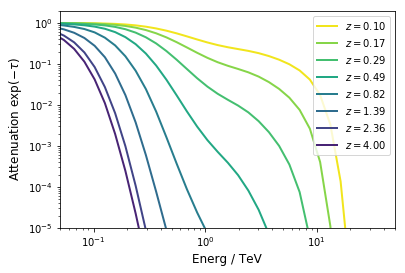

In [105]:
## New EBL method 
colors = np.array(['indigo', 'dimgray','thistle','darkslateblue','lightsteelblue',
                  'darkmagenta','lightgray','midnightblue'])

colors = np.array([viridis0,viridis2,viridis3,viridis4,viridis6,viridis7,viridis9,viridis10])

from ebltable.tau_from_model import OptDepth
tau =  OptDepth.readmodel(model = 'dominguez')
z = np.arange(0.1,4,0.45)
z = np.logspace(np.log10(0.1), np.log10(4), num=8)
ETeV = np.logspace(-2,2.5,50)
atten = np.exp(-1. * tau.opt_depth(z,ETeV))
for i,zz in enumerate(z):
    plt.loglog(ETeV,atten[i],
              ls = '-',color = colors[i],
              label = '$z = {0:.2f}$'.format(zz), lw = 2)

plt.gca().set_ylim((1e-5,2.))
plt.gca().set_xlim((5e-2,5e1))
plt.gca().set_xlabel('Energ / TeV',size = 'large')
plt.gca().set_ylabel(r'Attenuation $\exp(-\tau)$',size = 'large')
plt.legend(loc = 'upper right')
#plt.savefig('Plots/jpeg/New_EBL_Dom.jpg')
plt.savefig('Plots/New_EBL_Dom.pdf')
plt.show()